<a href="https://colab.research.google.com/github/RussiANC00lHACKA/ml_textbook/blob/main/Boosting_studentform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***О задаче***

### Контекст  
Важно, чтобы компании, выпускающие кредитные карты, могли распознавать мошеннические транзакции, чтобы клиенты не были обязаны оплачивать товары, которые они не покупали.

### Содержание  
Данный датасет содержит информацию о транзакциях, совершенных с использованием кредитных карт в сентябре 2013 года европейскими держателями карт.  

В этом датасете представлены транзакции за два дня, в ходе которых было зафиксировано 492 случая мошенничества из 284,807 транзакций. Датасет сильно несбалансирован: положительный класс (мошенничество) составляет всего 0.172% от всех транзакций.  

Датасет содержит только числовые признаки, которые были получены в результате преобразования методом PCA (анализ главных компонент). К сожалению, из-за вопросов конфиденциальности оригинальные признаки и дополнительная информация о данных недоступны. Признаки V1, V2, … V28 — это главные компоненты, полученные с помощью PCA. Единственными признаками, которые не подвергались преобразованию методом PCA, являются 'Time' и 'Amount'. Признак 'Time' содержит количество секунд, прошедших с момента первой транзакции в датасете до каждой следующей транзакции. Признак 'Amount' — это сумма транзакции, которую можно использовать для учета зависимости от примера при обучении с учетом стоимости ошибок. Признак 'Class' — это целевая переменная, принимающая значение 1 в случае мошенничества и 0 в противном случае.  

In [ ]:
! kaggle datasets download mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 85% 56.0M/66.0M [00:00<00:00, 160MB/s]
100% 66.0M/66.0M [00:00<00:00, 146MB/s]


In [ ]:
! unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df.shape

(284807, 31)

In [ ]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# ***Теория для дальнейшего понимания вопроса!***

Несбалансированные данные — это ситуация, чаще всего встречающаяся в задачах классификации, когда один из целевых классов значительно преобладает в выборке. Такие наборы данных характеризуются сильным дисбалансом в распределении классов, например, 1:100 или 1:1000 наблюдений в классе меньшинства по сравнению с классом большинства.

Проблема дисбаланса классов возникает в различных сферах, например:  

- **Обнаружение мошенничества**: подавляющее большинство транзакций относятся к классу «Не мошенничество».  
- **Медицинская диагностика**: большинство людей в выборке оказываются здоровыми.  
- **Анализ оттока подписчиков**: большинство пользователей остаются с сервисом, что формирует класс «Без оттока».  
- **Реклама и прогнозирование кликов**: данные о кликах обычно имеют крайне низкий уровень кликабельности.  

Существуют различные методы для устранения дисбаланса классов перед обучением модели, в том числе:  

- Увеличение числа наблюдений для класса меньшинства, используя знания о предметной области.  
- Модификация функции потерь, чтобы ошибки для класса меньшинства наказывались сильнее.  
- Увеличение выборки (oversampling) за счет создания или дублирования данных для класса меньшинства.  
- Уменьшение выборки (undersampling) за счет удаления или объединения данных для класса большинства.  
- Комбинация нескольких подходов.  

При увеличении выборки создаются новые или дублируются существующие примеры для класса меньшинства, а при уменьшении выборки удаляются или объединяются данные класса большинства. Несмотря на то, что увеличение выборки используется чаще всего, оно не всегда является лучшим решением.

Пример: ![Текст ссылки](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*miAWYUJ7sgWaRHCZMdP2OQ.png)

In [ ]:
labels=["Genuine","Class"]

fraud_or_not = df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

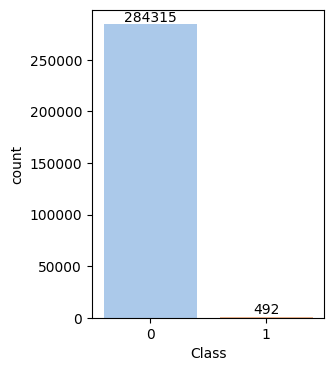

In [ ]:
plt.figure(figsize=(3,4));
ax = sns.countplot(x='Class',data=df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
print('Genuine:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% от датасета')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% от датасета')

Genuine: 99.83 % от датасета
Frauds: 0.17 % от датасета


Как по графикам можно заметить, мы занимаемся задачей с **несбалансированными данными** с экстремальными пропорциями, например, `99:1` или `99.9:0.1.`

Мы будем использовать именно бустинг с этими данными. **Но почему его?**

Мы выбираем его, потому что:

1. Он автоматически обращает внимание на редкие, сложные примеры.
2. У него есть настройки, чтобы учитывать дисбаланс (например, вес классов).
3. Он обычно дает точные результаты, даже если данные неидеальны.

# ***Точность классификации? (1 балл)***

Все вы знаете как работает точность и зачем она нужна!

Но какая же основная проблема этой метрики, связанная с дисбалансом классов и можно ли ее использовать в нашей задаче?

Ваш ответ здесь...

# ***Какие метрики будем использовать? (1 балл)***

- Предсказываете ли вы вероятности?
  - Нужны ли вам метки классов?
    - Является ли положительный класс более важным? - используйте **Precision-Recall AUC**
    - Оба класса важны? - используйте **ROC AUC**
  - Нужны ли вам вероятности? - используйте **Brier Score** и **Log-loss Score**

- Предсказываете ли вы метки классов?
  - Является ли положительный класс более важным?
    - Ложноотрицательные и ложноположительные равнозначно важны? - используйте **F1-Measure**
    - Ложноотрицательные важнее? - используйте **F2-Measure**
    - Ложноположительные важнее? - используйте **F0.5-Measure**
  - Оба класса важны?
    - Если доля большинства меньше 80%-90% - используйте **Accuracy**
    - Если доля большинства больше 80%-90% - используйте **G-Mean**


Что же мы будем использовать под нашу задачу?


Ваш ответ здесь...

# ***Удаление выбросов (1 балл)***
Нужно ли удалять выбросы, как вы думаете и если вы будете их удалять какой метод удаления будете использовать?

Ваш ответ здесь...

# ***Работа с данными***

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

***ВАЖНО:***
Нужно использовать ***стратифицированное разбиение***!
Обычно такие разделения набора данных выполняются случайным образом на основе целевой переменной. Однако при случайном разбиении пропорции целевой переменной в разных частях могут различаться, особенно в случае небольших наборов данных.

# ***Сама модель (3 балла)***

1. Сделайте свою бустинг модель
2. Посчитайте `ROC-AUC Score`, `Precision-Recall AUC`, `Classification_report` и `F1-Score`(все есть в sklearn)

In [ ]:
# Ваш код здесь ...

Улучшите свою модель так, чтобы на кросс-валидации с такими параметрами `StratifiedKFold(n_splits=5, shuffle=False)` средний f1-score был выше 0.86 и сделайте визуализацию важности признаков модели

In [ ]:
# Ваш код здесь ...

# ***Визуализация важности признаков (1 балл)***

In [ ]:
# Ваш код здесь ...

# ***Ансамбль моделей (3 балла)***

Попробуйте создать ансамбль из моделей и посчитайте все метрики, о которых говорилось в предыдущем задании!

In [ ]:
# Ваш код здесь ...

1. Улучшились ли какие-то значения метрик или нет?
2. Как вы считаете почему значения метрик улучшились или ухудшились по вашему мнению?
3. Дает ли какой-то существенный прирост показателей именно ансамль из моделей бустинга?

Ваш ответ здесь ...

***Замечание:*** ***Не обязательно делать новую продвинутую модель*** и улучшать ее по максимуму. Вы можете добавить достаточно простую модель в свою ансамль и просто порассуждать об изменении метрик и **что с ними стало** и **почему так произошло**!